# Chapter 2 End-to-End Machine Learning Project

Welcome to the Machine Learning Housing Corporation! Your first task is to
use California census data to build a model of housing prices in the state. This
data includes metrics such as the population, median income, and median
housing price for each block group in California. Block groups are the
smallest geographical unit for which the US Census Bureau publishes sample
data (a block group typically has a population of 600 to 3,000 people). We
will call them “districts” for short.

### What model to choose:
- it is clearly a typical supervised learning task, since you are given labeled training examples (each instance comes with the expected output, i.e., the district’s median housing price).
- It is also a typical regression task, since you are asked to predict a value. More specifically, this is a *multiple regression* problem, since the system will use multiple features to make a prediction (it will use the district’s population, the median income, etc.). 
- It is also a *univariate* regression problem, since we are only trying to predict a single value for each district. If we were trying to predict multiple values per district, it would be a *multivariate* regression problem.
- Finally, there is no continuous flow of data coming into the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain *batch learning* should do just fine.

### Select a Performance Measure
A typical performance measure for regression problems is the Root Mean Square Error (RMSE). It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors:

RMSE$(X,h)=\sqrt{\frac{1}{m} \sum \limits_{i=1}^m(h(x^i)-y^i)^2}$

- $m$ is the number of instances in the dataset you are measuring the RMSE on.
    - For example, if you are evaluating the RMSE on a validation set of 2,000 districts, then $m = 2,000$.
- $x^i$ is a vector of all the feature values (excluding the label) of the $i$th instance in the dataset, and $y^i$ is its label (the desired output value for that instance)
- $X$ is a matrix containing all the feature values (excluding labels) of all instances in the dataset. There is one row per instance, and the $i$th row is equal to the transpose of $x^i$, noted $(x)^⊺$.
- $h$ is your system’s prediction function, also called a _hypothesis_. When your system is given an instance’s feature vector $x^i$ , it outputs a predicted value $ŷ^i= h(x^i)$ for that instance ($ŷ$ is pronounced “y-hat”).
    - For example, if your system predicts that the median housing price in the first district is \\$158,400, then $ŷ^1 = h(x^1) = 158,400$. The prediction error for this district is $ŷ^1 – y^1 = 2,000$.
- RMSE$(X,h)$ is the cost function measured on the set of examples using your hypothesis $h$.


For example, suppose that there are many outlier districts. In that case, you may consider using the mean absolute error (MAE, also called the average absolute deviation:

MAE$(X,h) = \frac{1}{m}\sum \limits_{i=1}^m | h (x^i) - y^i|$


Both the RMSE and the MAE are ways to measure the distance between two vectors: the vector of predictions and the vector of target values.

- Computing the root of a sum of squares (RMSE) corresponds to the Euclidean norm.
- Computing the sum of absolutes (MAE) corresponds to the Manhattan norm.
- The $l_k$ norm of a vector $v$ containing n elements is defined as $||v||_k = (|v_0|^k+|v_1|^k+..+|v_n|^k)^\frac{1}{k}$.
- The higher the norm index, the more it focuses on large values and neglects small ones. This is why the RMSE is more sensitive to outliers than the MAE. But when outliers are exponentially rare (like in a bell-shaped curve), the RMSE performs very well and is generally preferred.

**Check the Assumptions!!!**

In [ ]:
# fetch the data
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url: str=HOUSING_URL,
                       housing_path: str=HOUSING_PATH) -> None:
    """Downloads and extracts housing data from the server"""
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
# Load dataset into Pandas
import pandas as pd

def load_housing_data(housing_path: str=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
fetch_housing_data()
df = load_housing_data()
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


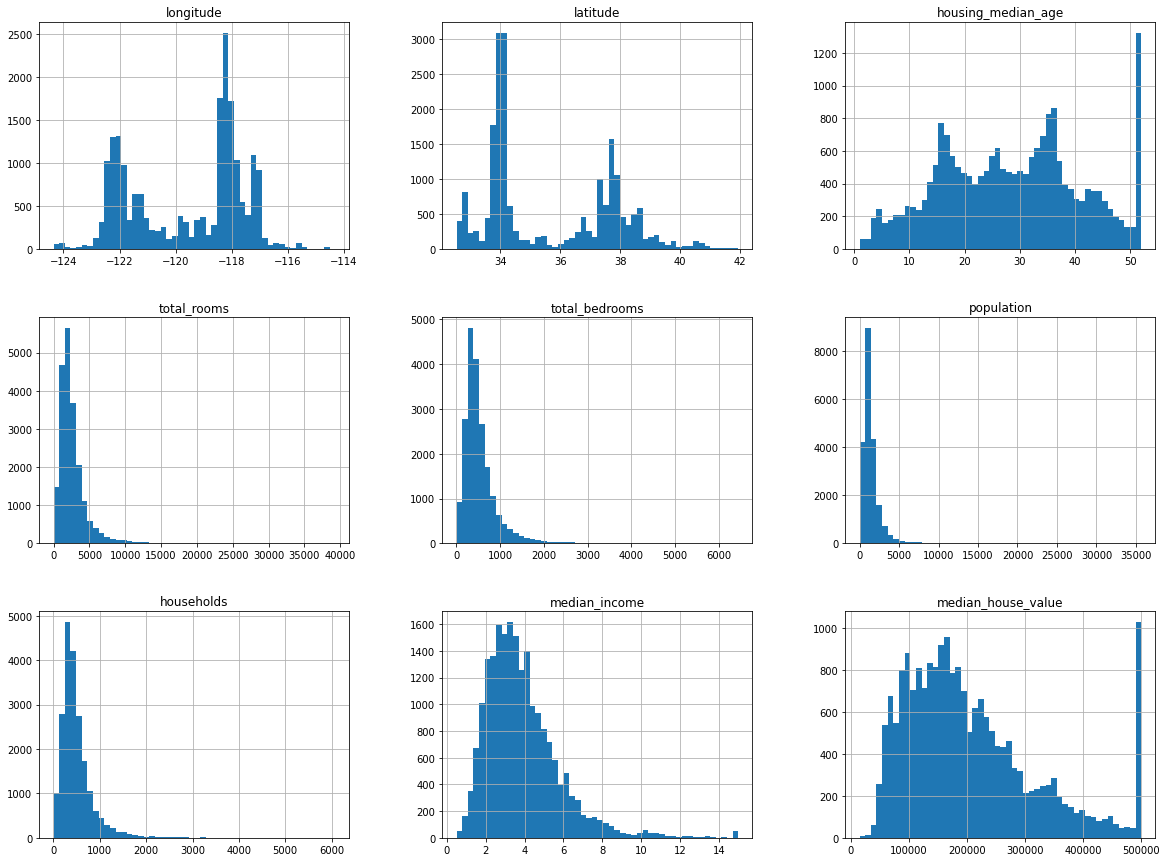

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(20,15))
plt.show()

1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughlytens of thousands of dollars (e.g., 3 actually means about \\$30,000). Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.
2. The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels).
3. Many histograms are tail-heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

## Create a test set

if you look at the test set, you may stumble upon some seemingly interesting pattern in the test data that leads you to select a particular kind of Machine Learning model. When you estimate the generalization error using the test set, your estimate will be too optimistic, and you will launch a system that will not perform as well as expected. This is called _data snooping_ bias.

In [9]:
import numpy as np

def split_train_test(data: pd, test_ratio: float) -> pd:
    """Splits dataframe into train test sets"""
    shuffled_indices = np.random.permutation(len(data))
    # Get percent the same percent of indices as test_ratio
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(df, 0.2)
print('Train set size:', len(train_set))
print('Test set size:', len(test_set))

Train set size: 16512
Test set size: 4128


Well, this works, but it is not perfect: if you run the program again, it will generate a different test set! Over time, you (or your Machine Learning algorithms) will get to see the whole dataset, which is what you want to avoid.

For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

In [11]:
from zlib import crc32

def test_set_check(identifier: str, test_ratio: int) -> str:
    """Compute a hash for each instance's identifier"""
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data: pd, 
                           test_ratio: int, 
                           id_column: str) -> pd:
    """
    Generates the hash for each instance and puts that 
    instance in the test set based on test_ratio
    """
    ids = data[id_column]
    in_test_set = ids.apply(
                    lambda id_: test_set_check(id_, test_ratio)
                )
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
housing_with_id = df.reset_index()
# adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset and that no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so:

In [13]:
housing_with_id["id"] = df["longitude"] * 1000 + df["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

We can do the same with `Scikit-learn` which provides similar function.

In [14]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

Most median income values are clustered around 1.5 to 6 (i.e., \\$15,000–\\$60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased.

The following code uses the `pd.cut()` function to create an income category attribute with five categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than \\$15,000), category 2 from 1.5 to 3, and so on:

In [15]:
df['income_cat'] = pd.cut(df['median_income'], 
                          bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf], 
                          labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

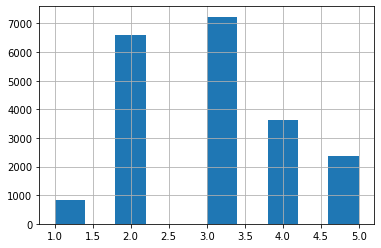

In [16]:
df['income_cat'].hist()

In [17]:
# Does stratified sampling based on the income category
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df['income_cat']):
    strata_train_set = df.loc[train_index]
    strata_test_set = df.loc[test_index]

In [18]:
# Let's test our results
strata_test_set["income_cat"].value_counts() / len(strata_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [19]:
# Now let's remove income_cat attribute
# so the data is back to its original state.
for set_ in (strata_train_set, strata_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights

* If the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast.

### Visualizing Geographical Data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

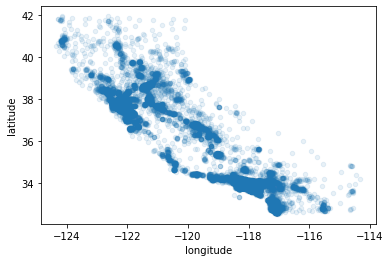

In [20]:
df.plot(kind='scatter', 
        x='longitude',
        y='latitude',
        alpha=0.1)

Let's look at the housing prices. The radius of each circle represents the district’s population (option **s**), and the color represents the price (option **c**). We will use a predefined color map (option **cmap**) called **jet**, which ranges from blue (low values) to red (high prices):

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

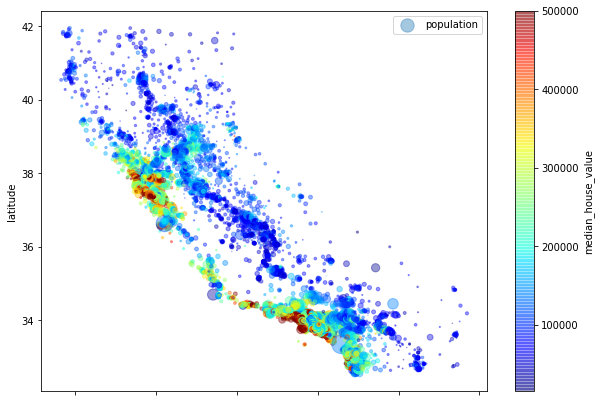

In [21]:
df.plot(
    kind='scatter', x='longitude', y='latitude', alpha=0.4, 
    s=df['population']/100, label='population', figsize=(10,7), 
    c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True
)

### Looking for Correlations

We can easily compute _standard correlation coefficient (Pearson's r)_ between every pair of attributes

In [22]:
corr_matrix = df.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

The correlation coefficient only measures linear correlations (“if x goes up, then y generally goes up/down”). It may completely miss out on nonlinear relationships (e.g., “if x is close to 0, then y generally goes up”).

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

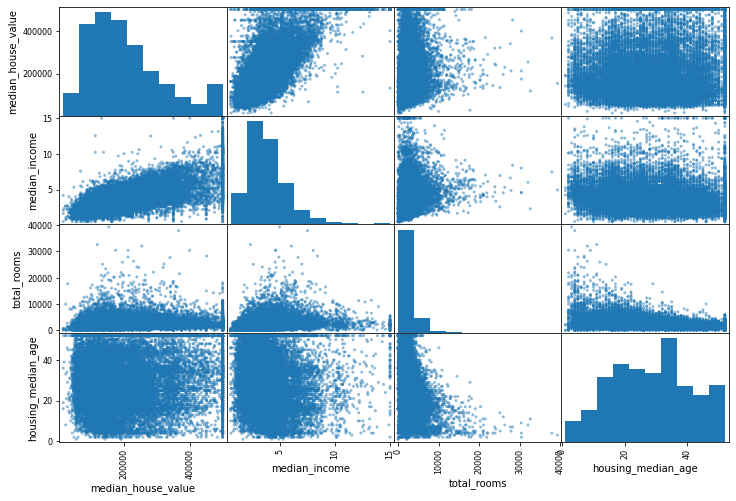

In [23]:
# Another way to check for correlation between attributes
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 
              'median_income', 
              'total_rooms', 
              'housing_median_age']
scatter_matrix(df[attributes], figsize=(12,8))

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot.

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

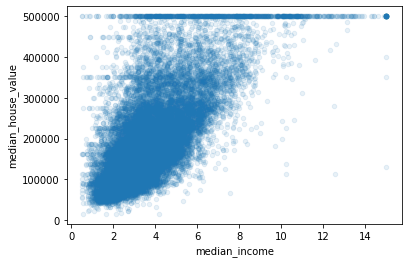

In [24]:
df.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

1. The correlation is indeed very strong; you can clearly see the upward trend, and the points are not too dispersed.
2. The price cap that we noticed earlier is clearly visible as a horizontal line at \\$500,000.
3. This plot reveals other less obvious straight lines: a horizontal line around \\$450,000, another around \\$350,000, perhaps one around \\$280,000, and a few more below that.

### Experimenting with Attribute Combinations
We noticed that some attributes have a tail-heavy distribution, so you may want to transform them (computing their logarithm).

Also, let's try out various attribute combinations. Let’s create these new attributes:

In [25]:
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["population_per_household"]= df["population"] / df["households"]

# Now let's loot at the correlation matrix again
corr_matrix = df.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

The new **bedrooms_per_room** attribute is much more correlated with the median house value than the total number of rooms or bedrooms.
Apparently houses with a lower bedroom/room ratio tend to be more expensive. This is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

## Prepare the Data for Machine Learning

Let's start by reverting to a clean training set. Also, let's seperate predictors and the labels.

In [26]:
housing = strata_train_set.drop("median_house_value", axis=1)
housing_labels = strata_train_set["median_house_value"].copy()

### Data Cleaning
To deal with missing values in **total_bedrooms** we have three options:
1. Get rid of the corresponding districts.
2. Get rid of the whole attribute.
3. Set the values to some value (zero, the mean, the median, etc.)

Here's how to do the same with Scikit-Learn. First, you need to create a `SimpleImputer` instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [27]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# Since the median can only be computed on numerical attributes, we
# create a copy of the data without the text attribute ocean_proximity
housing_num = housing.drop('ocean_proximity', axis=1)

# Now we fit the imputer instance to the training data
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The imputer has simply computed the median of each attribute and stored the result in its `statistics_` instance variable. it is safer to apply
the `imputer` to all the numerical attributes.

In [28]:
print('Imputer:', imputer.statistics_)
print('Medians:', housing_num.median().values)

Imputer: [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
Medians: [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [29]:
# Transform the traning set by replacing missing values medians
X = imputer.transform(housing_num)

# The result will be a plain NumPy array containing the transformed features.
housing_tr = pd.DataFrame(
        X, columns=housing_num.columns, index=housing_num.index)

### SCIKIT-LEARN DESIGN
Scikit-Learn’s API is remarkably well designed.

_Estimators_
- Any object that can estimate some parameters based on a dataset is called an _estimator_ (e.g., an `imputer` is an estimator). The estimation itself is performed by the `fit()` method, and it takes only a dataset as a parameter (or two for supervised learning algorithms; the second dataset contains the labels). Any other parameter needed to guide the estimation process is considered a hyperparameter (such as an imputer ’s `strategy` ), and it must be set as an instance variable (generally via a constructor parameter).

_Transformers_
- Some estimators (such as an imputer ) can also transform a dataset; these are called _transformers_. The transformation is performed by the `transform()` method with the dataset to transform as a parameter. It returns the transformed dataset. This transformation generally relies on the learned parameters, as is the case for an `imputer`. All transformers also have a convenience method called `fit_transform()` that is equivalent to calling `fit()` and then `transform()` (but sometimes `fit_transform()` is optimized and runs much faster).

_Predictors_ 
- Finally, some estimators, given a dataset, are capable of making predictions; they are called _predictors_. For example, the `LinearRegression` model in the previous chapter was a predictor: given a country’s GDP per capita, it predicted life satisfaction. A predictor has a `predict()` method that takes a dataset of new instances and returns a dataset of corresponding predictions. It also has a `score()` method that measures the quality of the predictions, given a test set (and the corresponding labels, in the case of supervised learning algorithms).

_Inspection_
- All the estimator’s hyperparameters are accessible directly via public instance variables (e.g., `imputer.strategy`), and all the estimator’s learned parameters are accessible via public instance variables with an underscore suffix (e.g., `imputer.statistics_`).

### Handling Text and Categorical Attributes
Let's look at the **ocean_proximity** attribute:

In [30]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


Let’s convert these categories from text to numbers. For this, we can use Scikit-Learn’s `OrdinalEncoder` class:

In [31]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [32]:
# We can get the list of categories
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and“excellent”), but it is obviously not the case for the **ocean_proximity** column.

To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is u“INLAND” (and 0 otherwise), and so on. This is called _one-hot encoding_, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

In [33]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a SciPy sparse matrix only stores the location of the nonzero elements. You can use it mostly like a normal 2D array, 21 but if you really want to convert it to a (dense) NumPy array, just call the `toarray()` method:

In [34]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [35]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need to do is create a class and implement three methods: `fit()` (returning `self`), `transform()` , and `fit_transform()`.

You can get the last one for free by simply adding `TransformerMixin` as a base class. If you add `BaseEstimator` as a base class (and avoid \*args and \*\*kargs in your constructor), you will also get two extra methods(`get_params()` and `set_params()`) that will be useful for automatic hyperparameter tuning.

In [36]:
# Example class
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """Combines and adds attributes to the given DataFrame"""
    
    def __init__(self, add_bedrooms_per_room: bool=True) -> None:
        # No *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            # Translates slice objects to concatenation along the second axis
            return np.c_[X, rooms_per_household,
                         population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [37]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about.

### Feature Scaling
Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. Note that scaling the target values is generally not required.

There are two common ways to get all attributes to have the same scale: 

_min-max scaling_:
- Min-max scaling (many people call this normalization) is the simplest: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called `MinMaxScaler` for this.

_standardization._
- First it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. Scikit-Learn provides a transformer called `StandardScaler` for standardization.

As with all the transformations, it is important to fit the scalers to the training data only.


### Transformation Pipelines
Scikit-Learn provides the `Pipeline` class to help with such sequences of transformations.

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('attribs_adder', CombinedAttributesAdder()),
                    ('std_dealer', StandardScaler()),
                ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

The `Pipeline` constructor takes a list of name/estimator pairs defining a sequence of steps.
All but the last estimator must be transformers (i.e., they must have a `fit_transform()` method). The names can be anything you like (as long as they are unique and don’t contain double underscores, __).

When you call the pipeline’s `fit()` method, it calls `fit_transform()` sequentially on all transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it calls the `fit()` method.

It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column.

In [39]:
from sklearn.compose import ColumnTransformer

# List of numerical column names
num_attribs = list(housing_num)

# List of categorical column names
cat_attribs = ['ocean_proximity']

'''
The constructor requires a list of tuples, where each tuple 
contains a name, a transformer, and a list of names (or indices)
of columns that the transformer should be applied to.
'''
full_pipeline = ColumnTransformer([
                    ('num', num_pipeline, num_attribs),
                    ('cat', OneHotEncoder(), cat_attribs),
                ])

# Create fully transformed dataframe
housing_prepared = full_pipeline.fit_transform(housing)

## Select and Train a Model


In [40]:
# Train a linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [41]:
# Try Linear model on few instances from the training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:', lin_reg.predict(some_data_prepared))
print('Labels:', list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [42]:
# Let's measure model's RMSE
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68628.19819848922


This is better than nothing, but clearly not a great score: most districts’ median_housing_values range between \\$120,000 and \\$265,000, so a typical prediction error of \\$68,628 is not very satisfying. This is an example of a model underfitting the training data.

In [43]:
# Let's train a Decision Tree Model
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

# Let's evaluate on a training set
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


Perfect fit? it's more like model has badly overfit data. As we saw earlier, you don’t want to touch the test setuntil you are ready to launch a model you are confident about, so you need to use part of the training set for training and part of it for model validation.

### Better Evaluation Using Cross-Validation

Greate way to evaluate a Decision Tree model is to use _K=fold cross-validation_ feature.

In [44]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

**WARNING**

Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes -scores before calculating the square root.

In [45]:
# Check the results
def display_scores(scores):
    """Prints the cross-validation scores"""
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard Deviation:', scores.std())
    
display_scores(tree_rmse_scores)

Scores: [69696.54730569 65585.06141395 71020.40802775 69227.21411845
 70802.32075225 75513.674699   69932.10478127 70139.84060963
 76619.88538483 69078.81450728]
Mean: 70761.5871600105
Standard Deviation: 3019.304629350273


The cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation).
The Decision Tree has a score of approximately 71,407, generally ±2,439. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible.


In [46]:
# Compute CV for Linear Model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                       scoring='neg_mean_squared_error', cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.674001798348


That’s right: the **Decision Tree** model is overfitting so badly that it performs worse than the **Linear Regression** model.

----
You should save every model you experiment with so that you can come back easily to
any model you want. Make sure you save both the hyperparameters and the trained
parameters, as well as the cross-validation scores and perhaps the actual predictions as
well. This will allow you to easily compare scores across model types, and compare the
types of errors they make. You can easily save Scikit-Learn models by using Python’s
`pickle` module or by using the `joblib` library, which is more efficient at serializing
large NumPy arrays (you can install this library using pip):

### Parameter vs Hyperparameter:

A model _parameter_ is a configuration variable that is internal to the model and whose value can be estimated from data. 

- The weights in an artificial neural network.
- The support vectors in a support vector machine.
- The coefficients in a linear regression or logistic regression

A model _hyperparameter_ is a configuration that is external to the model and whose value cannot be estimated from data.

- The learning rate for training a neural network.
- The C and sigma hyperparameters for support vector machines.
- The k in k-nearest neighbors.

If you have to specify a model parameter manually then it is probably a model hyperparameter.

## Fine-Tune Your Model

### Grid Search
To find a great combination of hyperparameter values we can use Scikit's `GridSearchCV` to search for us. All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values.

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Search for the best combination of hyperparameter values
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           refit=True)

grid_search.fit(housing_prepared, housing_labels)

'''When you have no idea what value a hyperparameter should have, a simple approach is
to try out consecutive powers of 10 (or a smaller number if you want a more fine-grained
search, as shown in this example with the n_estimators hyperparameter)'''

'When you have no idea what value a hyperparameter should have, a simple approach is\nto try out consecutive powers of 10 (or a smaller number if you want a more fine-grained\nsearch, as shown in this example with the n_estimators hyperparameter)'

This `param_grid` tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of n_estimators and max_features hyperparameter values specified in the first `dict`, hen try all 2 × 3 = 6 combinations of hyperparameter values in the second `dict`, but this time withthe bootstrap hyperparameter set to False instead of True (which is the default value for this hyperparameter).

The grid search will explore 12 + 6 = 18 combinations of RandomForestRegressor hyperparameter values, and it will train each model 5 times (As specified in `cv` argument). All in all, there will be 18 × 5 = 90 rounds of training! It may take quite a long time.

In [51]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [52]:
# Get the best estimator directly
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [53]:
# Evaluation Scores
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64064.32814078743 {'max_features': 2, 'n_estimators': 3}
55443.22016291406 {'max_features': 2, 'n_estimators': 10}
53118.78045568364 {'max_features': 2, 'n_estimators': 30}
60542.420769674485 {'max_features': 4, 'n_estimators': 3}
53212.77168293647 {'max_features': 4, 'n_estimators': 10}
50592.786826768985 {'max_features': 4, 'n_estimators': 30}
58868.82146909646 {'max_features': 6, 'n_estimators': 3}
52769.71702681606 {'max_features': 6, 'n_estimators': 10}
50176.973593031646 {'max_features': 6, 'n_estimators': 30}
59083.54987155549 {'max_features': 8, 'n_estimators': 3}
52432.03050280806 {'max_features': 8, 'n_estimators': 10}
50032.41657240629 {'max_features': 8, 'n_estimators': 30}
62496.88118882764 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53988.38006824648 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60614.10954401608 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52572.86741036294 {'bootstrap': False, 'max_features': 3, 'n_estimators':